In [39]:
# =============================================================================
# Cell 1: Configuration & Setup
# =============================================================================
# This cell contains all user settings.
# Modify the variables below to match your files and experimental design.
# =============================================================================

# --- 1. File Paths ---
# Path to your pathway mapping file (Excel format)
PATHWAY_FILE = "/PATH/TO/PATHWAY/MAPPING.xlsx"

# Path to your metabolite concentration data file (Excel format)
METABOLITE_FILE = "/PATH/TO/IMPUTED/DATA.xlsx"

# Directory where the output plots will be saved.
# If you don't want to save plots, set this to None: OUTPUT_DIR = None
OUTPUT_DIR = "PATH/TO/OUTPUT/D"


# --- 2. Data Structure Configuration ---
# Specify the sheet in the metabolite file to read from (e.g., 0 for the first, 1 for the second)
METABOLITE_SHEET_NAME = 0

# In your pathway file, specify the column index (0-based) for:
# - The pathway names
PATHWAY_NAME_COLUMN_INDEX = 0
# - The list of metabolites
PATHWAY_METABOLITES_COLUMN_INDEX = 2

# Specify the character used to separate metabolites in your pathway file (e.g., ',', ';', '|')
METABOLITE_DELIMITER = ';'


# --- 3. Sample & Timepoint Configuration ---
# Define how to identify conditions and timepoints from your sample column names.
# The regex MUST include a named group `(?P<timepoint>\d+)` to capture the timepoint identifier.
SAMPLE_NAMING_PATTERNS = [
    (r'TM2A(?P<timepoint>\d+)_', 'Treatment'),  # Pattern for treatment condition
    (r'TM2An(?P<timepoint>\d+)_', 'Control')   # Pattern for control condition
]

# Map the captured timepoint identifier (from the regex) to a numerical time value for plotting.
TIMEPOINT_MAP = {
    '1': 0,
    '2': 0.5,
    '3': 2,
    '4': 5,
    '5': 10
}


# --- 4. Analysis Parameters ---
# List the exact names of the pathways you wish to plot from your pathway file.
PATHWAYS_OF_INTEREST = [
    "Pantothenate and CoA Biosynthesis",
    "Amino Acid Metabolism",
    "TCA Cycle"
]

print("--- Configuration Loaded ---")

--- Configuration Loaded ---


Loading pathway data from: /users/aranpurdy/desktop/cfps/Pathway_enrichment/MAN_Pathways.xlsx
✓ Successfully loaded and parsed 7 pathways.
Loading metabolite data from: /users/aranpurdy/desktop/cfps/PCA/RF/MOD_RF_Imputed.xlsx
✓ Successfully loaded 115 metabolites across 50 samples.

Processing metabolite data...
✓ Data processing complete. Calculated mean and SEM for all timepoints.

--- Plotting Pathway: Pantothenate and CoA Biosynthesis ---
Found 8 matching metabolites to plot.
✓ Plot saved to: /users/aranpurdy/desktop/GIT/pathway_plots_new/Pantothenate_and_CoA_Biosynthesis.png


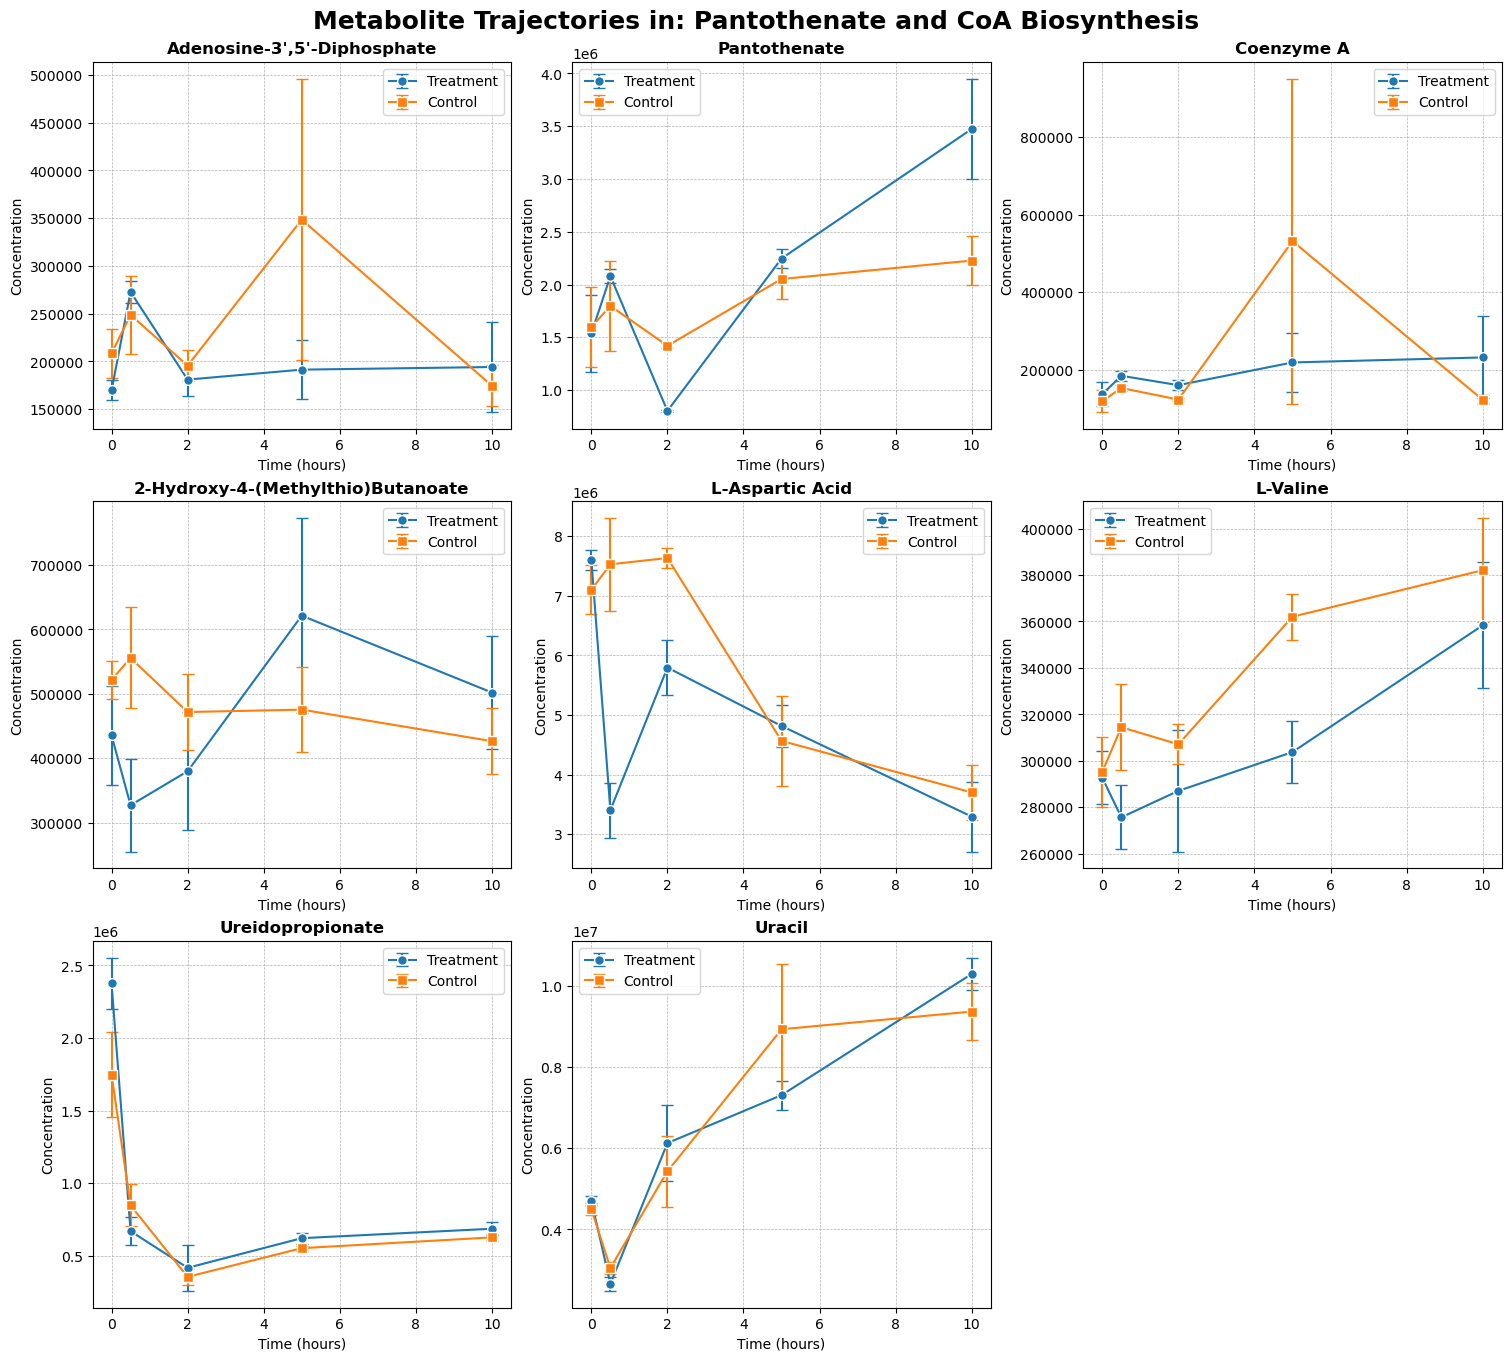


--- Plotting Pathway: Amino Acid Metabolism ---
Found 36 matching metabolites to plot.
✓ Plot saved to: /users/aranpurdy/desktop/GIT/pathway_plots_new/Amino_Acid_Metabolism.png


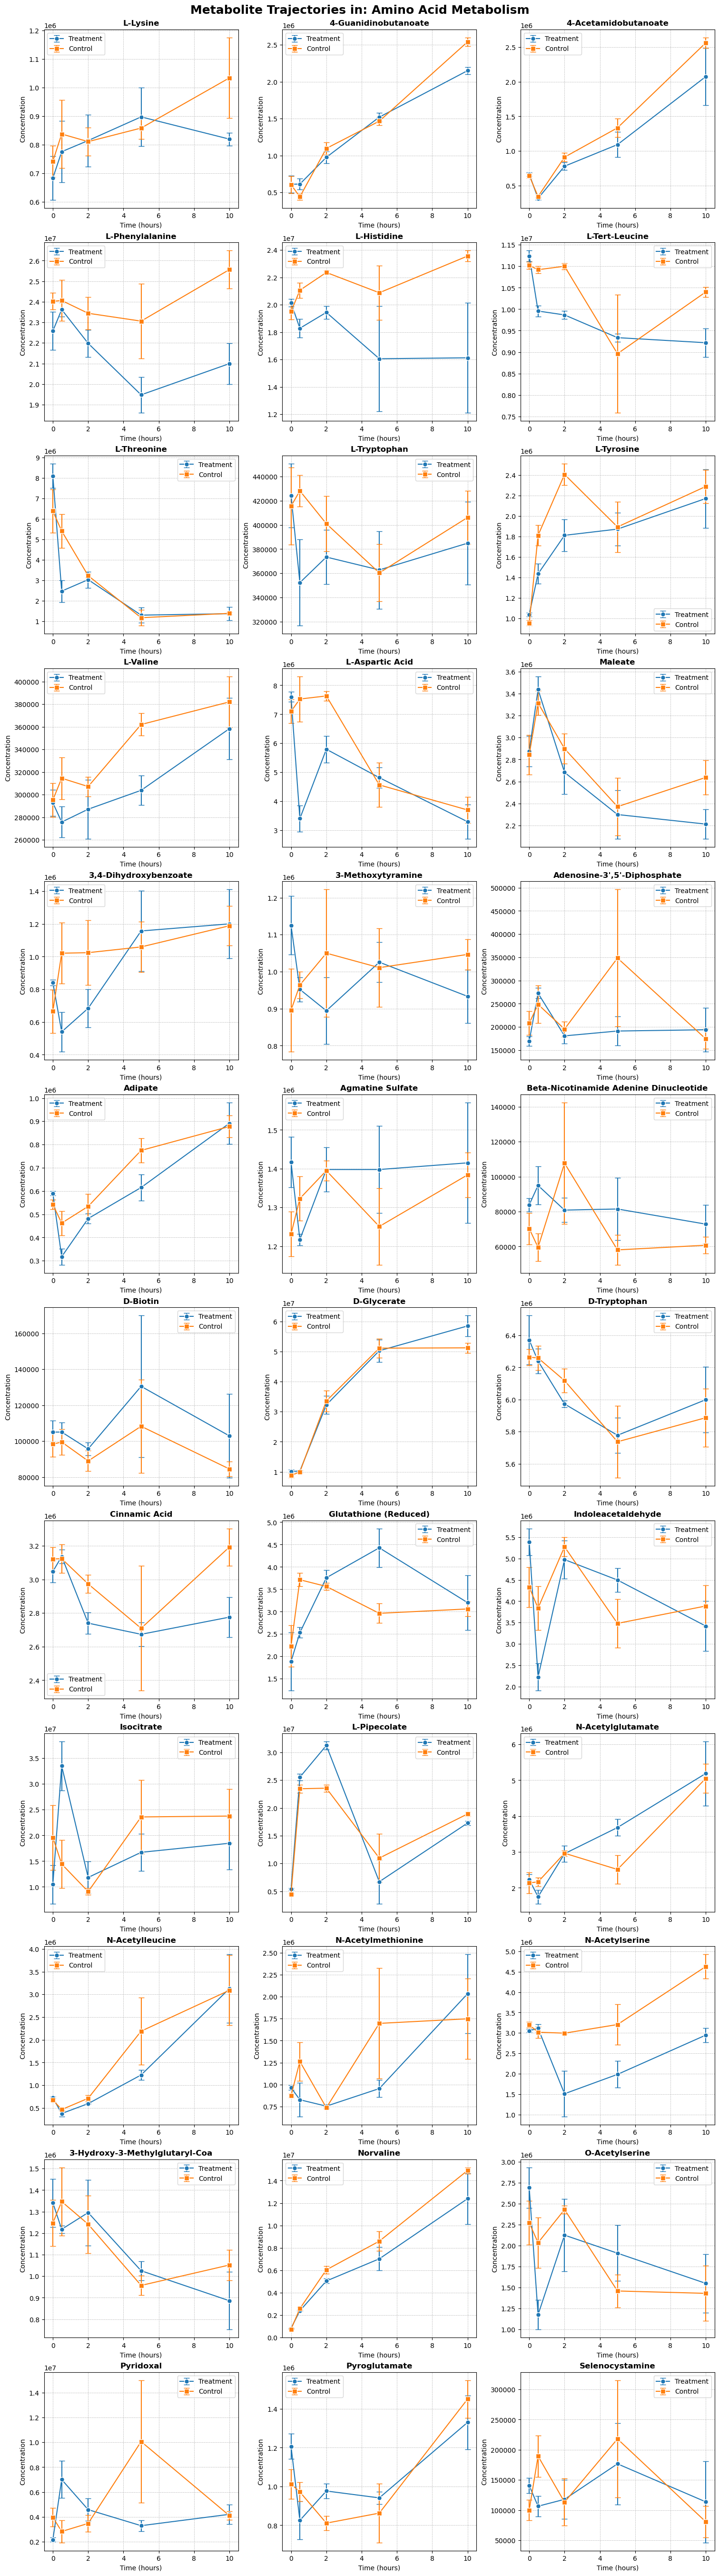


--- Plotting Pathway: TCA Cycle ---
Found 5 matching metabolites to plot.
✓ Plot saved to: /users/aranpurdy/desktop/GIT/pathway_plots_new/TCA_Cycle.png


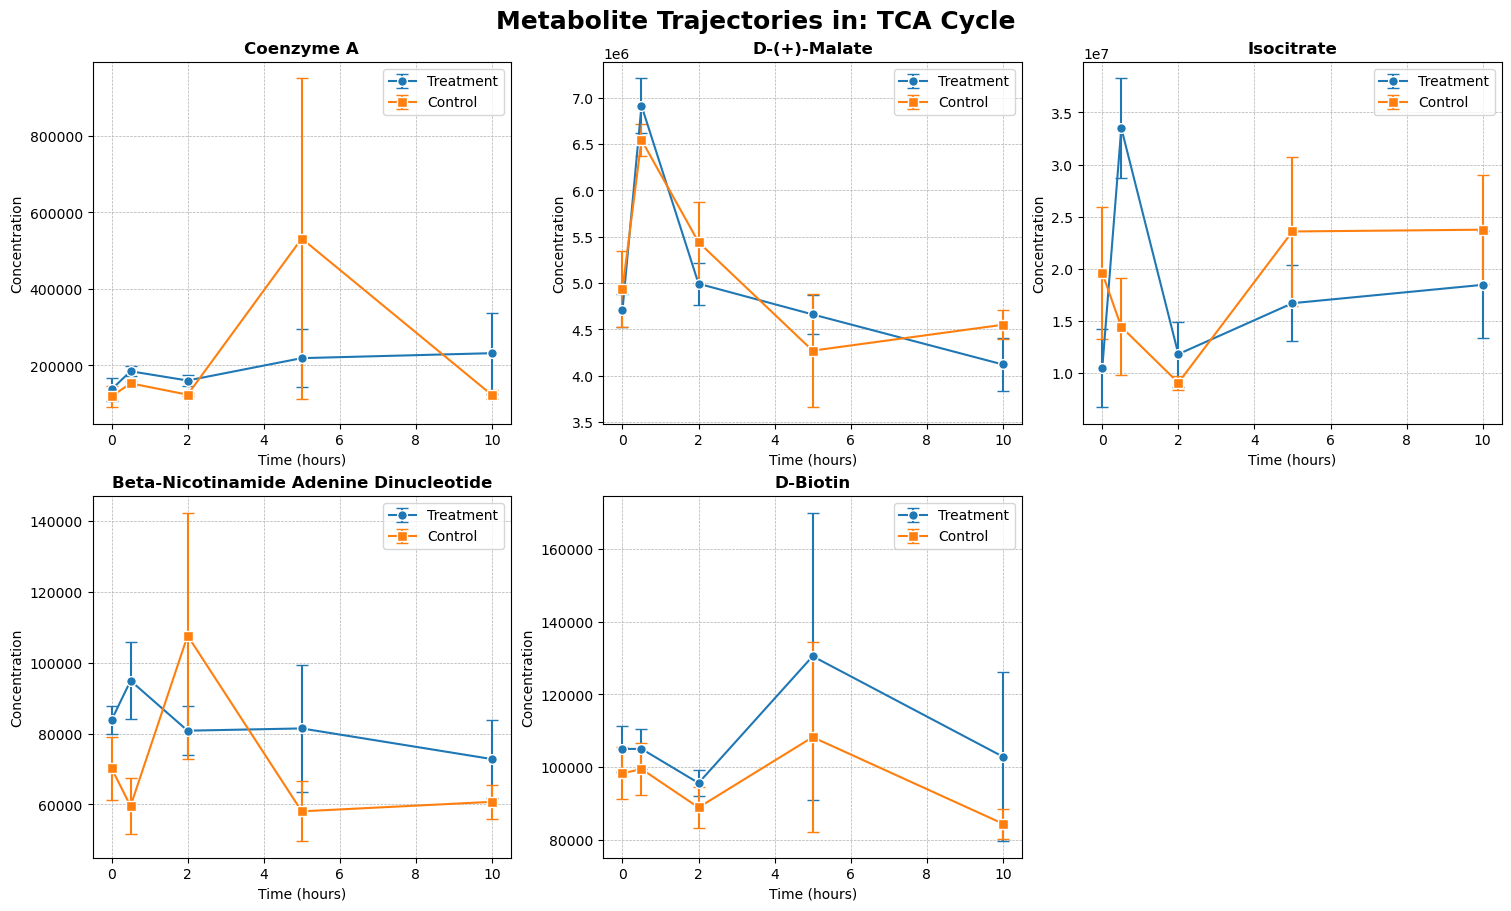

In [40]:
# =============================================================================
# Cell 2: Analysis Pipeline
# =============================================================================
# This cell contains the full script logic.
# Run this cell after setting your parameters in Cell 1.
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import warnings
warnings.filterwarnings('ignore')

# --- 1. Data Loading and Parsing Functions ---

def load_and_parse_pathways(filepath, name_col_idx, met_col_idx, delimiter):
    """Loads the pathway file and maps pathways to lists of metabolites."""
    print(f"Loading pathway data from: {filepath}")
    if not Path(filepath).exists():
        print("✗ ERROR: Pathway file not found. Please check the path in Cell 1.")
        return None
    try:
        df = pd.read_excel(filepath, header=None)
        pathway_dict = {}
        for _, row in df.iterrows():
            pathway_name = str(row[name_col_idx]).strip()
            metabolites_str = str(row[met_col_idx])
            if pd.notna(pathway_name) and pd.notna(metabolites_str):
                # <<< FIX: Convert metabolite names to lowercase for case-insensitive matching >>>
                metabolites = [m.strip().lower() for m in metabolites_str.split(delimiter) if m.strip()]
                pathway_dict[pathway_name] = metabolites
        print(f"✓ Successfully loaded and parsed {len(pathway_dict)} pathways.")
        return pathway_dict
    except Exception as e:
        print(f"✗ ERROR: Could not read the pathway file. Details: {e}")
        return None

def load_metabolite_data(filepath, sheet_name):
    """Loads the metabolite concentration data."""
    print(f"Loading metabolite data from: {filepath}")
    if not Path(filepath).exists():
        print("✗ ERROR: Metabolite file not found. Please check the path in Cell 1.")
        return None
    try:
        df = pd.read_excel(filepath, sheet_name=sheet_name, index_col=0)
        print(f"✓ Successfully loaded {df.shape[0]} metabolites across {df.shape[1]} samples.")
        return df
    except Exception as e:
        print(f"✗ ERROR: Could not read the metabolite file. Details: {e}")
        return None

# --- 2. Data Processing Function ---

def calculate_trajectory_stats(metabolite_df, patterns, timepoint_map):
    """Processes the wide-format metabolite data into a tidy format with statistics."""
    print("\nProcessing metabolite data...")
    
    metabolite_col_name = metabolite_df.index.name
    if metabolite_col_name is None:
        metabolite_col_name = 'Metabolite'
        metabolite_df.index.name = metabolite_col_name

    df_reset = metabolite_df.reset_index()

    tidy_df = df_reset.melt(
        id_vars=metabolite_col_name, var_name='Sample', value_name='Concentration'
    ).rename(columns={metabolite_col_name: 'Metabolite'})

    # <<< FIX: Convert metabolite names to lowercase for case-insensitive matching >>>
    tidy_df['Metabolite'] = tidy_df['Metabolite'].str.lower()

    def parse_sample(sample_name):
        for pattern, condition in patterns:
            match = re.search(pattern, sample_name)
            if match:
                try:
                    return condition, match.group('timepoint')
                except IndexError:
                    return 'Unknown', 'Unknown'
        return 'Unknown', 'Unknown'

    tidy_df[['Condition', 'TimepointID']] = tidy_df['Sample'].apply(
        lambda x: pd.Series(parse_sample(x))
    )

    tidy_df['Time'] = tidy_df['TimepointID'].map(timepoint_map)
    tidy_df = tidy_df.dropna(subset=['Time', 'Condition'])
    if tidy_df.empty:
        print("✗ ERROR: No samples matched the naming patterns. Please check SAMPLE_NAMING_PATTERNS in Cell 1.")
        return None

    stats_df = tidy_df.groupby(['Metabolite', 'Condition', 'Time']).agg(
        Mean=('Concentration', 'mean'),
        SEM=('Concentration', lambda x: x.sem())
    ).reset_index()
    
    print("✓ Data processing complete. Calculated mean and SEM for all timepoints.")
    return stats_df

# --- 3. Plotting Function ---

def plot_pathway(pathway_name, metabolites_in_pathway, stats_df, output_dir):
    """Generates and saves a multi-panel plot for all metabolites in a pathway."""
    print(f"\n--- Plotting Pathway: {pathway_name} ---")
    
    # Matching is now case-insensitive as both lists are lowercase
    valid_metabolites = [m for m in metabolites_in_pathway if m in stats_df['Metabolite'].unique()]
    
    if not valid_metabolites:
        print(f"✗ No matching metabolites for this pathway were found in the data file.")
        return

    print(f"Found {len(valid_metabolites)} matching metabolites to plot.")
    
    n_metabolites = len(valid_metabolites)
    n_cols = min(3, n_metabolites)
    n_rows = (n_metabolites + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4.5 * n_rows), constrained_layout=True)
    fig.suptitle(f'Metabolite Trajectories in: {pathway_name}', fontsize=18, fontweight='bold')
    
    axes = np.atleast_1d(axes).flatten()

    for i, met_name in enumerate(valid_metabolites):
        ax = axes[i]
        met_data = stats_df[stats_df['Metabolite'] == met_name]
        
        for condition, color, marker, label in [('Treatment', '#1f77b4', 'o', 'Treatment'), ('Control', '#ff7f0e', 's', 'Control')]:
            condition_data = met_data[met_data['Condition'] == condition].sort_values('Time')
            if not condition_data.empty:
                ax.errorbar(
                    x='Time', y='Mean', yerr='SEM', data=condition_data,
                    fmt=f'{marker}-', color=color, label=label,
                    capsize=4, markersize=7, markeredgecolor='white'
                )
        
        ax.set_title(met_name.title(), fontsize=12, fontweight='bold') # Use .title() for nicer display
        ax.set_xlabel('Time (hours)')
        ax.set_ylabel('Concentration')
        ax.legend()
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
        
    if output_dir:
        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)
        safe_filename = re.sub(r'[\\/*?:"<>|]', "", pathway_name).replace(" ", "_") + ".png"
        save_path = output_path / safe_filename
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Plot saved to: {save_path}")

    plt.show()


# --- 4. Main Execution Block ---

# Load data using configuration from Cell 1
pathway_map = load_and_parse_pathways(PATHWAY_FILE, PATHWAY_NAME_COLUMN_INDEX, PATHWAY_METABOLITES_COLUMN_INDEX, METABOLITE_DELIMITER)
metabolite_data = load_metabolite_data(METABOLITE_FILE, METABOLITE_SHEET_NAME)

# Proceed only if both files loaded successfully
if pathway_map and metabolite_data is not None:
    # Process data to calculate statistics for plotting
    trajectory_stats = calculate_trajectory_stats(metabolite_data, SAMPLE_NAMING_PATTERNS, TIMEPOINT_MAP)
    
    if trajectory_stats is not None:
        # Plot each pathway of interest
        for pathway in PATHWAYS_OF_INTEREST:
            if pathway in pathway_map:
                plot_pathway(
                    pathway_name=pathway,
                    metabolites_in_pathway=pathway_map[pathway],
                    stats_df=trajectory_stats,
                    output_dir=OUTPUT_DIR
                )
            else:
                print(f"\n✗ Warning: Pathway '{pathway}' not found in the pathway file. Skipping.")
    else:
         print("\n--- Analysis Halted due to data processing error. ---")
else:
    print("\n--- Analysis Halted due to data loading error. ---")